# Rozwiązywanie problemu komiwojażera (Traveling salesman problem)

Nazwa pochodzi od typowej ilustracji problemu, przedstawiającej go z punktu widzenia wędrownego sprzedawcy (komiwojażera): dane jest n miast, które komiwojażer ma odwiedzić, oraz odległość / cena podróży / czas podróży pomiędzy każdą parą miast. Celem jest znalezienie najkrótszej / najtańszej / najszybszej drogi łączącej wszystkie miasta, zaczynającej się i kończącej się w określonym punkcie (https://pl.wikipedia.org/wiki/Problem_komiwoja%C5%BCera)

In [1]:
import numpy as np
import math
import random
import time
import matplotlib.pyplot as plt
from tabulate import tabulate
from graphviz import Graph

from scipy.spatial.distance import cityblock
from scipy.spatial.distance import chebyshev

import pygad

import pyswarms as ps
from pyswarms.utils.functions import single_obj as fx
from pyswarms.utils.plotters import plot_cost_history


Do mierzenia odległości między puntami użyjemy metryki euklidesowej obliczanej za pomocą wzoru
$ d(a,b) = \sqrt{ (a_{1}-b_{1})^{2} + \ldots + (a_{n}-b_{n})^{2} } $ (https://pl.wikipedia.org/wiki/Przestrze%C5%84_euklidesowa#Definicja_metryki_euklidesowej).

In [2]:
def metryka_euklidesowa(a, b):
    return np.linalg.norm(a - b)

## Algorytm genetyczny (Genetic algorithm)

Zaczniemy od próby rozwiązania tego problemu za pomocą algorytmu genetycznego (https://pl.wikipedia.org/wiki/Algorytm_genetyczny). Do uruchomienia tego algorytmu użyjemy paczki PyGen (https://pygen.readthedocs.io/en/latest/). 

Rozwiązania podane przez algorytm będą listą indeksów miejsc uporządkowaną w kolejności, w jakiej będziemy je odwiedzać. Ważnym parametrem jest allow_duplicate_genes=False, który zapewni nam brak powtórzeń w rozwiązaniu, to znaczy, nie będziemy odwiedzać miejsc kilkukrotnie. Funkcja fitness_euklid będzie mierzyć łączną odległość między punktami w zadanej kolejności, zaczynając i kończąc w punkcie start. Zwracamy wartość tej odległości pomnożoną przez -1, ponieważ algorytm szuka maksimum a my chcemy odnaleźć jak najkrótszą drogę. Stworzymy listę lokacji długości 10 złożoną z losowych współrzędnych x i y, a jako punkt startowy wybierzemy (0,0).

In [3]:
def fitness_euklid(solution, solution_idx):
    sol = [int(i) for i in solution]
    droga = metryka_euklidesowa(start, np.array((lokacje[sol[0]][0], lokacje[sol[0]][1])))

    for i in range(1, len(solution)):
        prev = np.array((lokacje[sol[i-1]][0], lokacje[sol[i-1]][1]))
        now = np.array((lokacje[sol[i]][0], lokacje[sol[i]][1]))
        droga = droga + metryka_euklidesowa(now, prev)
    
    droga = droga + metryka_euklidesowa(now, start)
    
    return -droga

In [4]:
x = [random.randint(0,50) for a in range(10)]
y = [random.randint(0,50) for a in range(10)]
lokacje = list(zip(x, y))
start = [0,0]
lokacje

[(9, 37),
 (45, 30),
 (22, 29),
 (1, 40),
 (7, 12),
 (25, 13),
 (24, 12),
 (43, 13),
 (38, 31),
 (35, 22)]

Parameters of the best solution : [3. 0. 2. 9. 8. 1. 7. 5. 6. 4.]
Fitness value of the best solution = -162.567463488327
TIME:  0.8497564792633057


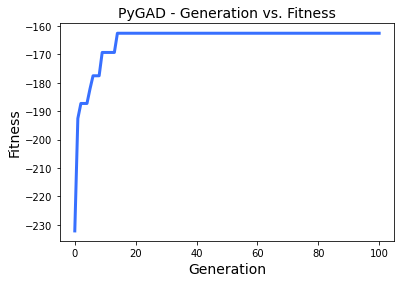

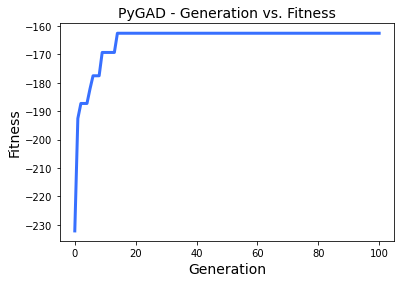

In [5]:
gs = [i for i in range(len(lokacje))]

ga_instance = pygad.GA(gene_space = gs,
                        num_generations = 100,
                        num_parents_mating = 5,
                        fitness_func = fitness_euklid,
                        sol_per_pop = 60,
                        num_genes = len(lokacje),
                        parent_selection_type = "sss",
                        keep_parents = 2,
                        crossover_type = "single_point",
                        mutation_type='random',
                        mutation_percent_genes=10,
                        allow_duplicate_genes=False)

start_time = time.time()
ga_instance.run()
end_time = time.time()

solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))
print("TIME: ", end_time-start_time)
ga_instance.plot_fitness()

Sprawdzimy, jak wydłuża się czas działania algorytmu genetycznego w zależności od liczby miejsc, które musimy odwiedzić. 

In [6]:
czas = []

for i in range(5, 31):
    t = []
    for j in range(10):
        x = [random.randint(0,50) for a in range(i)]
        y = [random.randint(0,50) for a in range(i)]
        lokacje = list(zip(x, y))
        start = [0,0]

        gs = [i for i in range(len(lokacje))]

        ga_instance = pygad.GA(gene_space = gs,
                                num_generations = 1500,
                                num_parents_mating = 5,
                                fitness_func = fitness_euklid,
                                sol_per_pop = 50,
                                num_genes = len(lokacje),
                                parent_selection_type = "sss",
                                keep_parents = 2,
                                crossover_type = "single_point",
                                mutation_type='random',
                                mutation_num_genes=1, 
                                allow_duplicate_genes=False,
                                stop_criteria='saturate_150')

        start_time = time.time()
        ga_instance.run()
        end_time = time.time()
        
        t.append(end_time - start_time)
    
    czas.append(np.mean(t))

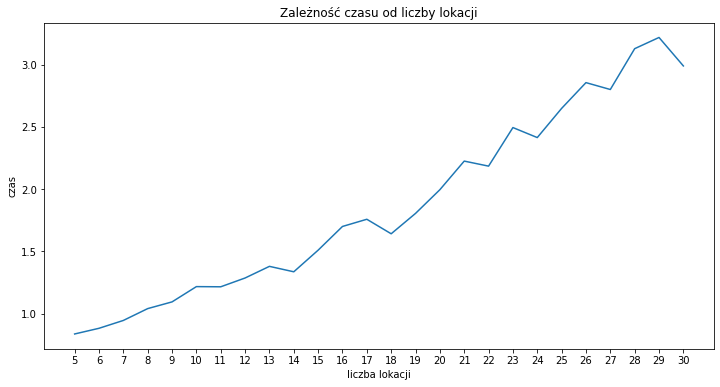

In [7]:
plt.figure(figsize=[12,6])
plt.plot([i for i in range(5, 31)], czas)
plt.title('Zależność czasu od liczby lokacji')
plt.xlabel('liczba lokacji')
plt.ylabel('czas')
plt.xticks([i for i in range(5,31)])
plt.show()

Widzimy, że czas zauważalnie wydłuża się przy większej liczbie lokacji.

## Metryki

Do mierzenia odległości między punktami możemy użyć również innych metryk, nie tylko euklidesowej. Metryka miejska (lub Manhattan, taksówkarza) to metryka, w której odległość między dwoma punktami jest sumą bezwzględnych różnic ich współrzędnych kartezjańskich $ d(a,b) = \sum_{i=1}^{n} |a_{i}-b_{i}|$ (https://en.wikipedia.org/wiki/Taxicab_geometry). W Pythonie do obliczenia tej metryki mozemy użyć funckji cityblock (https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cityblock.html). Sprawdzimy, czy średni czas działania algorytmu genetycznego różni się w zależności od wybranej metryki.

In [8]:
def fitness_cityblock(solution, solution_idx):
    sol = [int(i) for i in solution]
    
    droga = cityblock(start, np.array((lokacje[sol[0]][0], lokacje[sol[0]][1])))
    
    for i in range(1, len(solution)):
        prev = np.array((lokacje[sol[i-1]][0], lokacje[sol[i-1]][1]))
        now = np.array((lokacje[sol[i]][0], lokacje[sol[i]][1]))
        droga = droga + cityblock(now, prev)
    
    droga = droga + cityblock(now, start)
    
    return -droga

Metryka maksimum, zwana także metryką nieskończoność, maksimum, Czebyszewa, szachową, jest określona za pomocą wzoru
$ d(a,b) = \max_{i} |a_{i} - b_{i}| $ (https://pl.wikipedia.org/wiki/Odleg%C5%82o%C5%9B%C4%87_Czebyszewa). 
W szachach jest to odległość między polami szachownicy wyrażona w ruchach, które musi wykonać figura króla. Stąd pochodzi jej angielska nazwa chessboard distance. W Pythonie do obliczenia tej metryki mozemy użyć funckji chebyshev (https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.chebyshev.html#scipy.spatial.distance.chebyshev) 

In [9]:
def fitness_chebyshev(solution, solution_idx):
    sol = [int(i) for i in solution]
    
    droga = chebyshev(start, np.array((lokacje[sol[0]][0], lokacje[sol[0]][1])))
    
    for i in range(1, len(solution)):
        prev = np.array((lokacje[sol[i-1]][0], lokacje[sol[i-1]][1]))
        now = np.array((lokacje[sol[i]][0], lokacje[sol[i]][1]))
        droga = droga + chebyshev(now, prev)
    
    droga = droga + chebyshev(now, start)
    
    return -droga

In [10]:
x = [random.randint(0,50) for a in range(15)]
y = [random.randint(0,50) for a in range(15)]
lokacje = list(zip(x, y))
start = [0,0]
gs = [i for i in range(len(lokacje))]

In [11]:
czas_euc = []
czas_cb = []
czas_cheb =[]

for i in range(10):
    ga_instance = pygad.GA(gene_space = gs,
                            num_generations = 1000,
                            num_parents_mating = 5,
                            fitness_func = fitness_euklid,
                            sol_per_pop = 100,
                            num_genes = len(lokacje),
                            parent_selection_type = "sss",
                            keep_parents = 2,
                            crossover_type = "single_point",
                            mutation_type='random',
                            mutation_percent_genes=7,
                            allow_duplicate_genes=False,
                            stop_criteria='saturate_100')

    start_time = time.time()
    ga_instance.run()
    end_time = time.time()
    solution, solution_fitness, solution_idx = ga_instance.best_solution()
    czas_euc.append(end_time - start_time)
    
    ga_instance = pygad.GA(gene_space = gs,
                            num_generations = 1000,
                            num_parents_mating = 5,
                            fitness_func = fitness_cityblock,
                            sol_per_pop = 100,
                            num_genes = len(lokacje),
                            parent_selection_type = "sss",
                            keep_parents = 2,
                            crossover_type = "single_point",
                            mutation_type='random',
                            mutation_percent_genes=7,
                            allow_duplicate_genes=False,
                            stop_criteria='saturate_100')

    start_time = time.time()
    ga_instance.run()
    end_time = time.time()
    solution, solution_fitness, solution_idx = ga_instance.best_solution()
    czas_cb.append(end_time - start_time)
    
    ga_instance = pygad.GA(gene_space = gs,
                            num_generations = 1000,
                            num_parents_mating = 5,
                            fitness_func = fitness_chebyshev,
                            sol_per_pop = 100,
                            num_genes = len(lokacje),
                            parent_selection_type = "sss",
                            keep_parents = 2,
                            crossover_type = "single_point",
                            mutation_type='random',
                            mutation_percent_genes=7,
                            allow_duplicate_genes=False,
                            stop_criteria='saturate_100')

    start_time = time.time()
    ga_instance.run()
    end_time = time.time()
    solution, solution_fitness, solution_idx = ga_instance.best_solution()
    czas_cheb.append(end_time - start_time)

In [12]:
data = [[np.mean(czas_euc), np.mean(czas_cb), np.mean(czas_cheb)]]
col_names = ["metryka euklidesowa", "metryka miejska", 'metryka czebyszewa']
print(tabulate(data, headers=col_names, numalign="center", tablefmt="fancy_grid"))

╒═══════════════════════╤═══════════════════╤══════════════════════╕
│  metryka euklidesowa  │  metryka miejska  │  metryka czebyszewa  │
╞═══════════════════════╪═══════════════════╪══════════════════════╡
│        1.97113        │      1.97361      │       1.78701        │
╘═══════════════════════╧═══════════════════╧══════════════════════╛


## Inteligencja roju (Particle swarm optimization)

Inteligencja roju jest metodą obliczeniową, która optymalizuje problem poprzez iteracyjne próby ulepszenia potencjalnego rozwiązania w odniesieniu do danej miary jakości . Rozwiązuje problem, mając populację potencjalnych rozwiązań, tutaj nazwanych cząstkami, i przesuwając te cząstki w przestrzeni poszukiwań zgodnie z prostym wzorem matematycznym nad położeniem i prędkością cząstki.
(https://en.wikipedia.org/wiki/Particle_swarm_optimization)
Do uruchomienia tego algorytmu użyjemy paczki PySwarms (https://pyswarms.readthedocs.io/en/latest/index.html).

Do rozwiązania naszego problemu użyjemy funkcji BinaryPSO. Potrzebujemy rozwiązania w postaci listy kolejno odwiedzanych miejsc, natomiast ten algorytm zwraca nam listę zer i jedynek. Przekształcimy tę listę w macierz o wymiarze liczby miejsc. Suma wartości w kolejnych wierszach określi nam kolejność odwiedzania miejsc. Następnie odrzucimy rozwiązania zawierające powtórzenia. Niestety, jest to brutalne rozwiązanie i może utrudnić algorytmowi wyszukiwanie rozwiązań. Funkcja dist_func mierzy łączną długość przebytej trasy metryką euklidesową. Tym razem wynik zwracamy bez minusa, ponieważ ten algorytm wyszukuje minimum.

In [13]:
n = 5
x = [random.randint(0,50) for a in range(n)]
y = [random.randint(0,50) for a in range(n)]
lokacje = list(zip(x, y))
start = (0,0)
lokacje

[(23, 40), (20, 49), (1, 19), (10, 37), (45, 25)]

In [14]:
def dist_func(droga):
    sol = [int(i) for i in droga]
    fit = metryka_euklidesowa(start, np.array((lokacje[sol[0]][0], lokacje[sol[0]][1])))

    for i in range(1, len(droga)):
        prev = np.array((lokacje[sol[i-1]][0], lokacje[sol[i-1]][1]))
        now = np.array((lokacje[sol[i]][0], lokacje[sol[i]][1]))
        fit = fit + metryka_euklidesowa(now, prev)
    fit = fit + metryka_euklidesowa(now, start)
    return fit

In [15]:
def f1(solution):
    fitnes = 0
    for sol in solution:
        m = np.array(sol)
        m = m.reshape(n, n)
        
        droga = np.array([])
        for i in m:
            droga = np.append(droga, sum(i)-1)
        
        if len(np.unique(droga)) != len(droga) or np.any(droga == -1):
            fitness = n**(5)
        else:
            fitness = dist_func(droga)
        
    return fitness

2023-04-02 20:36:52,658 - pyswarms.discrete.binary - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9, 'k': 2, 'p': 1}
pyswarms.discrete.binary:  40%|█████████████████████████▋                                      |402/1000, best_cost=165
2023-04-02 20:37:05,513 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 165.18927076942936, best pos: [0 0 1 1 1 0 0 1 0 0 1 1 1 1 1 1 1 0 1 0 1 1 0 1 1]


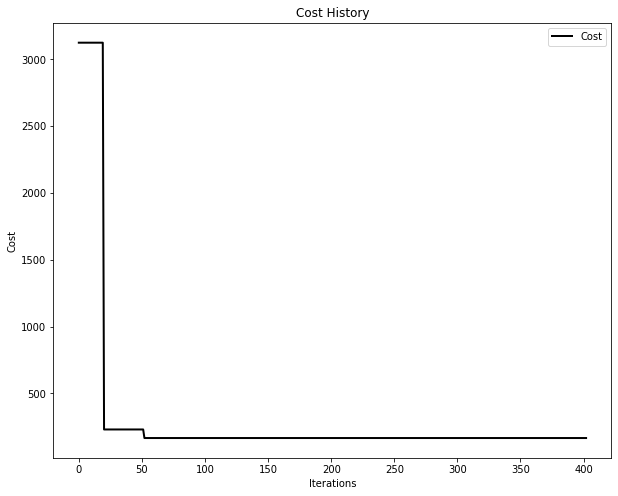

In [16]:
options = {'c1': 0.5, 'c2': 0.3, 'w':0.9, 'k':2, 'p':1}
optimizer = ps.discrete.BinaryPSO(n_particles=500, dimensions=n*n, options=options, ftol=1e-3, ftol_iter=350)
cost, pos = optimizer.optimize(f1, iters=1000)
cost_history = optimizer.cost_history
plot_cost_history(cost_history)
plt.show()

Spróbujemy teraz użyć funkcji GlobalBestPSO. Określimy ograniczenia dla dziedziny, w której szukamy minimum, aby nie dostać indeksu poza granicami. Następnie otrzymane wartości zaokrąglimy do pełnych liczb. Niestety, również tutaj będziemy musieli odrzucić wszystkie rozwiązania z powtórzeniami. Zwracamy łączną długość trasy obliczoną za pomocą funkcji dist_func.

In [17]:
def f2(solution):
    fitnes = 0
    for sol in solution:
        m = np.array([])
        for i in sol:
            m = np.append(m, round(i))
        
        if len(np.unique(m)) != len(m):
            fitness = n**(5)
        else:
            fitness = dist_func(m)
            
    return fitness

2023-04-02 20:37:05,727 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:  76%|██████████████████████████████████████████████               |755/1000, best_cost=182
2023-04-02 20:37:24,705 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 181.55474699692996, best pos: [1.26086075 1.61989056 2.04761351 1.54156492 1.16832668]


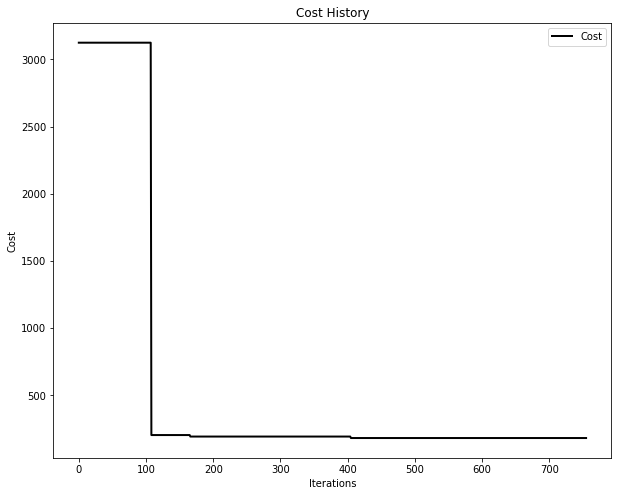

In [18]:
x_max = np.full((n), n-1)
x_min = np.zeros(n)
my_bounds = (x_min, x_max)

options = {'c1': 0.5, 'c2': 0.3, 'w':0.9}
optimizer = ps.single.GlobalBestPSO(n_particles=500, dimensions=n, bounds=my_bounds, 
                                    options=options, ftol=1e-3, ftol_iter=350)
cost, pos = optimizer.optimize(f2, iters=1000)
cost_history = optimizer.cost_history
plot_cost_history(cost_history)
plt.show()

Uruchomimy obydwa algorytmy kilkukrotnie i przyjrzymy się ich najlepszym rozwiązaniom.

In [19]:
rozw1 = []
rozw2 = []

for i in range(10):
    options = {'c1': 0.5, 'c2': 0.3, 'w':0.9, 'k':2, 'p':1}
    optimizer = ps.discrete.BinaryPSO(n_particles=500, dimensions=n*n, options=options, ftol=1e-3, ftol_iter=350)
    cost, pos = optimizer.optimize(f2, iters=1000, verbose=False)
    rozw1.append(pos)
    
    options = {'c1': 0.5, 'c2': 0.3, 'w':0.9}
    optimizer = ps.single.GlobalBestPSO(n_particles=500, dimensions=n, bounds=my_bounds, 
                                        options=options, ftol=1e-3, ftol_iter=350)
    cost, pos = optimizer.optimize(f2, iters=1000, verbose=False)
    rozw2.append(pos)

In [20]:
print('Rozwiązania BinaryPSO:')
for sol in rozw1:
        m = np.array(sol)
        m = m.reshape(n, n)
        
        droga = np.array([])
        for i in m:
            droga = np.append(droga, sum(i)-1)
        print(droga, '\t', len(np.unique(droga)))

print('Rozwiązania GlobalBestPSO:')
for sol in rozw2:
        m = np.array([])
        for i in sol:
            m = np.append(m, round(i))
        print(m, '\t', len(np.unique(m)))

Rozwiązania BinaryPSO:
[-1.  2.  2.  1.  1.] 	 3
[1. 2. 1. 0. 1.] 	 3
[3. 1. 3. 1. 2.] 	 3
[1. 2. 2. 1. 1.] 	 2
[1. 3. 3. 0. 1.] 	 3
[2. 1. 1. 1. 2.] 	 2
[1. 4. 0. 1. 2.] 	 4
[3. 1. 0. 3. 2.] 	 4
[2. 2. 1. 3. 1.] 	 3
[1. 1. 3. 0. 2.] 	 4
Rozwiązania GlobalBestPSO:
[1. 3. 3. 0. 3.] 	 3
[0. 4. 2. 2. 0.] 	 3
[4. 2. 2. 4. 1.] 	 3
[3. 3. 2. 2. 1.] 	 3
[2. 1. 2. 3. 4.] 	 4
[3. 1. 1. 3. 2.] 	 3
[1. 4. 2. 2. 1.] 	 3
[2. 1. 2. 2. 1.] 	 2
[2. 2. 3. 1. 3.] 	 3
[1. 1. 2. 2. 1.] 	 2


Możemy zobaczyć, że żadne z rozwiązań nie jest drogą bez powtórzeń, co oznacza, że wszystkie rozwiązania są błędne.

### Praktyczny przykład

Skorzystamy z macierzy ze strony https://developers.google.com/optimization/routing/tsp. Macierz odległości to macierz, której elementy $a_{i,j}$ są odległością od lokalizacji $i$ do lokalizacji $j$ w milach, gdzie indeksy tablicy odpowiadają lokalizacjom w następującej kolejności:
0. Nowy Jork - 1. Los Angeles - 2. Chicago - 3. Minneapolis - 4. Denver - 5. Dallas - 6. Seattle - 7. Boston - 8. San Francisco - 9. St. Louis - 10. Houston - 11 Phoenix - 12. Salt Lake City.
Kolejność lokalizacji w macierzy odległości jest dowolna i nie ma związku z kolejnością lokalizacji w jakimkolwiek rozwiązaniu problemu. 

Naszym zadaniem będzie odnalezienie miasta startowego, dla którego trasa przez wszystkie pozostałe miasta i powrót do startu będzie najkrótsza. Użyjemy do tego algorytmu genetycznego. Tutaj nie musimy obliczać odległości pomiędzy poszczególnymi miastami. Zamiast tego musimy zsumować odpowiednie elementy z macierzy. Rozwiązanie przedstawimy na grafie wykonanym za pomocą paczki Graphviz (https://graphviz.readthedocs.io/en/stable/index.html).

In [21]:
mtrx = [[0, 2451, 713, 1018, 1631, 1374, 2408, 213, 2571, 875, 1420, 2145, 1972],
        [2451, 0, 1745, 1524, 831, 1240, 959, 2596, 403, 1589, 1374, 357, 579],
        [713, 1745, 0, 355, 920, 803, 1737, 851, 1858, 262, 940, 1453, 1260],
        [1018, 1524, 355, 0, 700, 862, 1395, 1123, 1584, 466, 1056, 1280, 987],
        [1631, 831, 920, 700, 0, 663, 1021, 1769, 949, 796, 879, 586, 371],
        [1374, 1240, 803, 862, 663, 0, 1681, 1551, 1765, 547, 225, 887, 999],
        [2408, 959, 1737, 1395, 1021, 1681, 0, 2493, 678, 1724, 1891, 1114, 701],
        [213, 2596, 851, 1123, 1769, 1551, 2493, 0, 2699, 1038, 1605, 2300, 2099],
        [2571, 403, 1858, 1584, 949, 1765, 678, 2699, 0, 1744, 1645, 653, 600],
        [875, 1589, 262, 466, 796, 547, 1724, 1038, 1744, 0, 679, 1272, 1162],
        [1420, 1374, 940, 1056, 879, 225, 1891, 1605, 1645, 679, 0, 1017, 1200],
        [2145, 357, 1453, 1280, 586, 887, 1114, 2300, 653, 1272, 1017, 0, 504],
        [1972, 579, 1260, 987, 371, 999, 701, 2099, 600, 1162, 1200, 504, 0]]

miasta = ['New York', 'Los Angeles', 'Chicago', 'Minneapolis', 'Denver', 'Dallas', 'Seattle', 'Boston',
          'San Francisco', 'St. Louis', 'Houston', 'Phoenix', 'Salt Lake City']

In [22]:
def fitness_usa(solution, solution_idx):
    sol = [int(i) for i in solution]
    droga = mtrx[start][sol[0]]
    for i in range(len(sol)-1):
        droga = droga + mtrx[sol[i]][sol[i+1]]
    droga = droga + mtrx[sol[-1]][start]
    return -droga

In [23]:
rozw = []
trasy = []

for i in range(len(miasta)):
    gs = []
    if i > 0:
        gs.append([j for j in range(i)])
    if i < 12:
        gs.append([j for j in range(i+1, len(miasta))])
    
    gs = [item for sublist in gs for item in sublist]
    start = i
    
    ga_instance = pygad.GA(gene_space = gs,
                            num_generations = 300,
                            num_parents_mating = 5,
                            fitness_func = fitness_usa,
                            sol_per_pop = 50,
                            num_genes = len(miasta)-1,
                            parent_selection_type = "sss",
                            keep_parents = 2,
                            crossover_type = "single_point",
                            mutation_type='random',
                            mutation_num_genes=1,
                            allow_duplicate_genes=False,
                            stop_criteria='saturate_100')

    start_time = time.time()
    ga_instance.run()
    end_time = time.time()

    solution, solution_fitness, solution_idx = ga_instance.best_solution()
    rozw.append((-1)*solution_fitness)
    trasy.append(solution)

In [24]:
drogi = trasy[rozw.index(min(rozw))]
ind = rozw.index(min(rozw))

trasa = np.array([ind])
trasa = np.append(trasa, drogi)
trasa = np.append(trasa, [ind])
trasa = [int(i) for i in trasa]

miastanodes = miasta
for i in range(len(drogi)):
    miastanodes[int(drogi[i])] = str(i+1) + '. ' + miasta[int(drogi[i])]

In [25]:
dot = Graph(strict='True')

dot.attr(label=r'\n\nNajkrótsza znaleziona trasa: '+str(min(rozw))+' mil', fontsize='25')

for i in miastanodes:
    if i == miastanodes[ind]:
        dot.node(i, color='green', style='filled')
    else:
        dot.node(i)

for j in range(len(miastanodes)):
    for i in range(j+1, len(miastanodes)):
        dot.edge(miastanodes[j], miastanodes[i], label=str(mtrx[i][j]))

for k in range(len(trasa)-1):
    dot.edge(miastanodes[trasa[k]], miasta[trasa[k+1]], 
             label=str(mtrx[trasa[k]][trasa[k+1]]), fontcolor='green',
             color='green', penwidth='3')

dot.render('usa', view=True)

'usa.pdf'